In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

# Percolation

In [2]:
# get the data
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')

In [3]:
edges.head()

,from,to,l,h,time,timeU,timeUCB,border
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0
3,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0
4,8211,1054396,50.646909,primary,75.970364,90.055660,90.055660,0


In [4]:
nodes.head()

,Agglomeration_ID,agglosName,x,y,Pop2015,ISO3,Region,Between,degree
0,2320,Cairo,31.324,30.130,22995802,EGY,North,6.979617e+07,6
1,5199,Lagos,3.316,6.668,11847635,NGA,West,3.127663e+07,4
2,7098,Onitsha,6.928,5.815,8530514,NGA,West,2.110388e+07,6
3,4220,Johannesburg,28.016,-26.050,8314220,ZAF,South,3.568974e+07,5
4,4858,Kinshasa,15.293,-4.408,7270000,COD,Central,1.119784e+06,4


In [5]:
# convert it to a network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

In [6]:
# set the nodes attributes (dict keys are the node IDs)
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

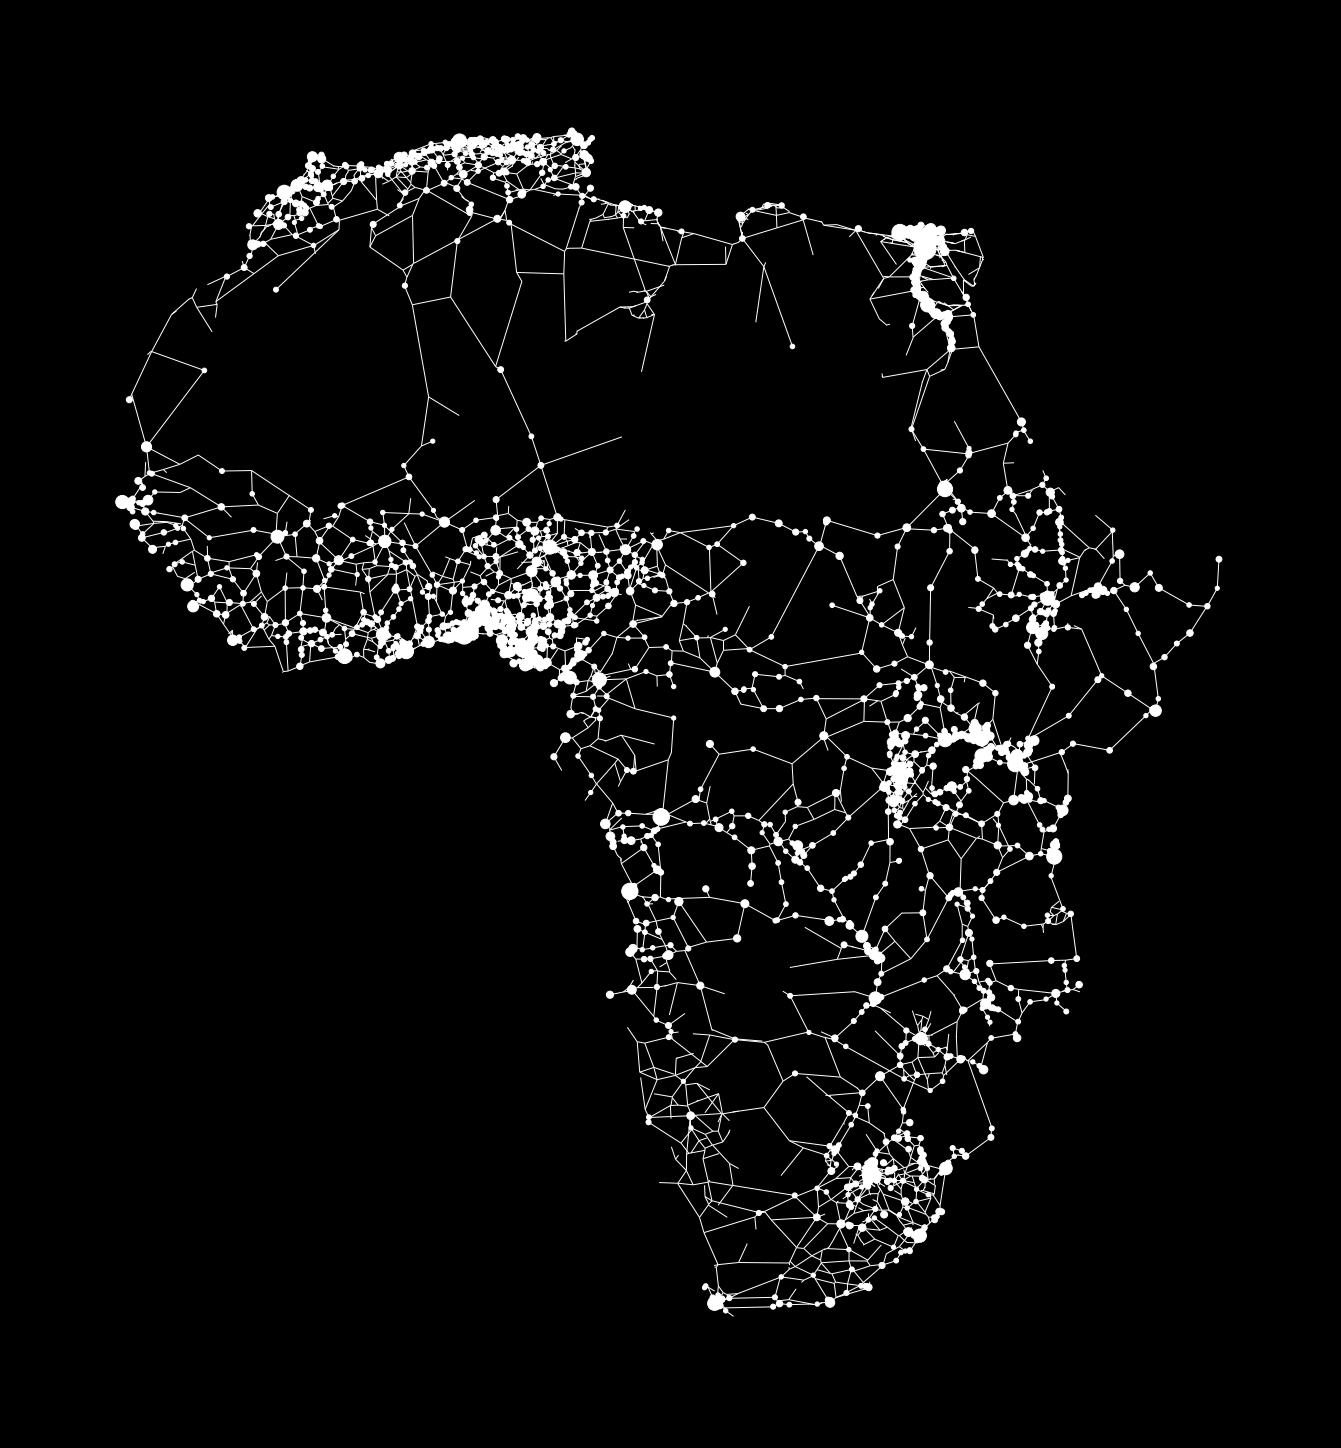

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

position = {n: [d['x'], d['y']] for n, d in G.nodes(data=True)}
size = [np.sqrt(d['Pop2015'] / 100) for n, d in G.nodes(data=True)]

nx.draw_networkx_edges(G, ax=ax, pos=position, edge_color='w', alpha=1)
nx.draw_networkx_nodes(G, ax=ax, pos=position, node_color='w', node_size=size, alpha=1)
ax.set_facecolor('k')

In [44]:
# use colorcet to get a nice color palette
from colorcet import palette
from matplotlib import colors
# break it up by the number of nodes
pal = np.tile(palette['glasbey_light'], len(nodes) // len(palette['glasbey_light']))
pal = colors.ListedColormap(pal)

In [38]:
# a basemap
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]

In [39]:
lengths = []
components = list()

# make a lost of lengths and remove edges longer than that length
for i in np.arange(0, edges.l.max()):
    G_ = G.copy()
    # cut the edges, aka the key move
    _ = [G_.remove_edge(u, v) for u, v, d in G.edges(data=True) if d['l'] > i]
    
    # save all the data
    labels = pd.DataFrame({u: i for i, n in enumerate(sorted(nx.connected_components(G_), key=len, reverse=True)) for u in n}, index=['component']).T
    labels['threshold'] = i
    labels['gcc'] = len(max(nx.connected_components(G_), key=len))
    
    lengths.append(len(max(nx.connected_components(G_), key=len)))
    components.append(labels)

# the dataframe will have a node index and which component it belongs to, plut a threshold to indicate which round of cuts we are in    
components = pd.concat(components)
components.head()

,component,threshold,gcc
8211,0,0.0,1
2333,1,0.0,1
1000559,2,0.0,1
1000567,3,0.0,1
5425,4,0.0,1


In [40]:
# clean things up
edges_copy = edges.copy()
nodes_copy = nodes.copy()

components_copy = components[components.threshold.isin(np.append(np.arange(10, 450, 10), 600))].merge(nodes_copy, 
                                                                                                      left_index=True, right_on='Agglomeration_ID', how='left')


components_copy['aggnm'] = components_copy['agglosName']
components_copy['pop15'] = components_copy['Pop2015']
components_copy['thrno'] = components_copy['threshold']
components_copy['thrid'] = components_copy['threshold'].astype(int).astype(str).str.pad(fillchar="0", side='left', width=7)
components_copy['comid'] = components_copy['component'].astype(str).str.pad(fillchar="0", side='left', width=7)
components_copy['aggid'] = components_copy['Agglomeration_ID'].astype(str).str.pad(fillchar="0", side='left', width=7)

components_copy = components_copy[['aggnm', 'pop15', 'thrno', 'thrid', 'comid', 'aggid', 'gcc', 'Agglomeration_ID']]
components_copy.head()

,aggnm,pop15,thrno,thrid,comid,aggid,gcc,Agglomeration_ID
2707,road,0,10.0,0000010,0000000,1034241,178,1034241
3669,road,0,10.0,0000010,0000000,1073668,178,1073668
5258,road,0,10.0,0000010,0000000,1179141,178,1179141
2795,road,0,10.0,0000010,0000000,1044489,178,1044489
3706,road,0,10.0,0000010,0000000,1075214,178,1075214


In [41]:
# let's get the biggest city in each component
biggest = components_copy.sort_values('pop15', ascending=False).groupby(['thrid', 'comid'], as_index=False).first()
# then rank them
biggest['biggest_rank'] = biggest.pop15.rank(ascending=True, method='dense')
# then get total population and total cities in each component
n_comps = components_copy[components_copy['aggnm']!='road'].groupby(['thrid', 'comid'], as_index=False).agg({'pop15': ['count', 'sum']})
# clean up the column names
n_comps.columns = [''.join(x) for x in n_comps.columns]

In [42]:
# merge it all together so we have the biggest city, its population, and the total population and number of cities in each component
components_copy = components_copy.merge(biggest[['thrid', 'comid', 'aggnm', 'pop15', 'biggest_rank']].rename(columns={'aggnm': 'biggest_city', 'pop15': 'biggest_pop'}), 
                                        left_on=['thrid', 'comid'], 
                                        right_on=['thrid', 'comid'], 
                                        how='left').merge(n_comps, 
                                                          left_on=['thrid', 'comid'], 
                                                          right_on=['thrid', 'comid'], 
                                                          how='left').sort_values('pop15count', ascending=False)

Text(0.5, 0.98, 'Size of Giant Connected Component')

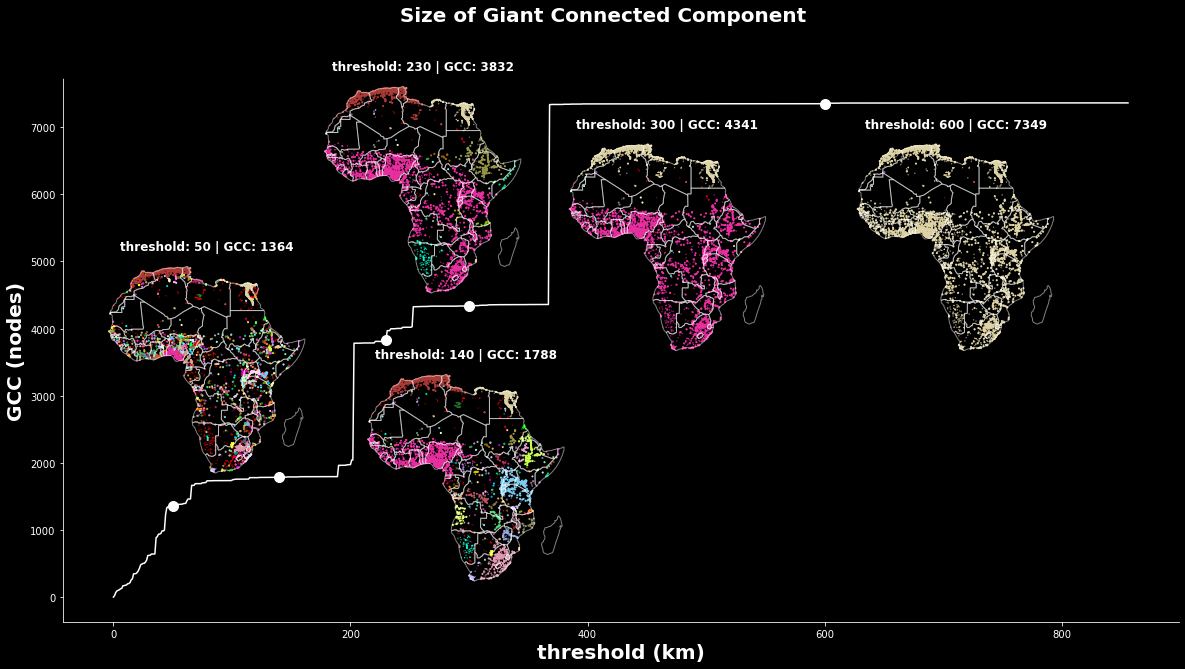

In [45]:
size = [0.15, 0.35]
# at which thresholds do we want to show the percolation plots
selection = [50, 140, 230, 300, 600]
# get the x and y coordinates of the points
points = components[components.threshold.isin(selection)].groupby('threshold').first().reset_index()

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')
ax.plot(np.arange(0, edges.l.max()), lengths, color='w')

# add subplots for each threshold
for i, j in zip(selection, [[0.15, 0.30], [0.33, 0.15], [0.30, 0.55], [0.47, 0.47], [0.67, 0.47]]):
    
    sub = plt.axes(j + size, facecolor='#000000')
    
    temp_comps = components_copy[components_copy['thrno']==i]

    g = temp_comps.gcc.iloc[0]

    temp_nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
    temp_nodes = temp_nodes.merge(temp_comps, left_on='Agglomeration_ID', right_on='Agglomeration_ID')
    temp_nodes['component'] = temp_nodes['biggest_rank']
    
    temp_marks= (np.log(temp_nodes['Pop2015'] + 1) + 1) / 10
    temp_nodes.plot('component', markersize=temp_marks, cmap=pal, ax=sub)
    
    africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)
    sub.set_title(f"threshold: {i} | GCC: {temp_comps.gcc.iloc[0]}", color='w', weight='bold')
    sub.set_axis_off()
    
ax.scatter(points.threshold.to_numpy(), points.gcc.to_numpy(), s=100, c='w')

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("threshold (km)", color="w", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="w", fontdict=font)

fig.suptitle('Size of Giant Connected Component', color='w', size=20, weight='bold')